In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import os

from summer.utils import ref_times_to_dti

from autumn.tools.project import load_timeseries
from autumn.tools.plots.utils import REF_DATE
from autumn.tools.runs import ManagedRun
from autumn.tools.runs.calibration.utils import get_posteriors
from autumn.tools.utils.pandas import pdfilt
from autumn.settings.region import Region

## Specify the runs of interest

In [2]:
run_id = "sm_sir/bangladesh/1648462328/5bddda7"

In [3]:
mr = ManagedRun(run_id)

2022-03-30 22:45:20.274 INFO    botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials


In [4]:
full_run = mr.full_run.get_derived_outputs()
pbi = mr.powerbi.get_db()
targets = pbi.get_targets()
results = pbi.get_uncertainty()
mcmc_params = mr.calibration.get_mcmc_params()

2022-03-30 22:45:20.817 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-0/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-0\derived_outputs.feather


2022-03-30 22:45:27.204 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-1/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-1\derived_outputs.feather


2022-03-30 22:45:33.854 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-10/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-10\derived_outputs.feather


2022-03-30 22:45:40.541 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-11/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-11\derived_outputs.feather


2022-03-30 22:45:47.233 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-12/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-12\derived_outputs.feather


2022-03-30 22:45:53.520 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-13/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-13\derived_outputs.feather


2022-03-30 22:45:59.759 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-14/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-14\derived_outputs.feather


2022-03-30 22:46:06.379 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-15/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-15\derived_outputs.feather


2022-03-30 22:46:13.128 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-16/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-16\derived_outputs.feather


2022-03-30 22:46:20.185 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-17/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-17\derived_outputs.feather


2022-03-30 22:46:27.134 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-18/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-18\derived_outputs.feather


2022-03-30 22:46:33.980 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-19/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-19\derived_outputs.feather


2022-03-30 22:46:40.892 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-2/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-2\derived_outputs.feather


2022-03-30 22:46:47.885 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-20/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-20\derived_outputs.feather


2022-03-30 22:46:55.180 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-21/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-21\derived_outputs.feather


2022-03-30 22:47:01.920 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-22/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-22\derived_outputs.feather


2022-03-30 22:47:09.285 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-23/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-23\derived_outputs.feather


2022-03-30 22:47:15.794 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-24/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-24\derived_outputs.feather


2022-03-30 22:47:22.046 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-25/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-25\derived_outputs.feather


2022-03-30 22:47:28.332 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-26/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-26\derived_outputs.feather


2022-03-30 22:47:34.550 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-27/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-27\derived_outputs.feather


2022-03-30 22:47:40.876 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-28/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-28\derived_outputs.feather


2022-03-30 22:47:47.292 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-29/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-29\derived_outputs.feather


2022-03-30 22:47:53.659 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-3/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-3\derived_outputs.feather


2022-03-30 22:48:00.356 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-30/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-30\derived_outputs.feather


2022-03-30 22:48:07.400 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-31/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-31\derived_outputs.feather


2022-03-30 22:48:14.587 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-32/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-32\derived_outputs.feather


2022-03-30 22:48:20.731 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-33/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-33\derived_outputs.feather


2022-03-30 22:48:26.527 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-34/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-34\derived_outputs.feather


2022-03-30 22:48:32.712 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-35/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-35\derived_outputs.feather


2022-03-30 22:48:38.645 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-36/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-36\derived_outputs.feather


2022-03-30 22:48:44.914 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-37/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-37\derived_outputs.feather


2022-03-30 22:48:51.032 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-38/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-38\derived_outputs.feather


2022-03-30 22:48:57.023 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-39/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-39\derived_outputs.feather


2022-03-30 22:49:03.301 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-4/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-4\derived_outputs.feather


2022-03-30 22:49:09.601 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-40/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-40\derived_outputs.feather


2022-03-30 22:49:15.637 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-41/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-41\derived_outputs.feather


2022-03-30 22:49:22.378 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-42/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-42\derived_outputs.feather


2022-03-30 22:49:28.483 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-43/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-43\derived_outputs.feather


2022-03-30 22:49:34.623 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-44/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-44\derived_outputs.feather


2022-03-30 22:49:40.874 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-45/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-45\derived_outputs.feather


2022-03-30 22:49:47.091 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-46/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-46\derived_outputs.feather


2022-03-30 22:49:53.184 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-47/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-47\derived_outputs.feather


2022-03-30 22:49:59.062 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-5/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-5\derived_outputs.feather


2022-03-30 22:50:05.785 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-6/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-6\derived_outputs.feather


2022-03-30 22:50:12.014 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-7/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-7\derived_outputs.feather


2022-03-30 22:50:18.727 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-8/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-8\derived_outputs.feather


2022-03-30 22:50:25.050 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/full_model_runs/chain-9/derived_outputs.feather to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-9\derived_outputs.feather


2022-03-30 22:50:31.688 INFO    autumn.tools.db.process: Collating db outputs into c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\full_run_collated.db
2022-03-30 22:50:31.723 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-0
2022-03-30 22:50:31.725 INFO    autumn.tools.db.process: Copying table derived_outputs
2022-03-30 22:50:38.149 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-1
2022-03-30 22:50:38.152 INFO    autumn.tools.db.process: Copying table derived_outputs
2022-03-30 22:50:44.327 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-10
2022-03-

2022-03-30 22:53:28.423 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-34
2022-03-30 22:53:28.425 INFO    autumn.tools.db.process: Copying table derived_outputs
2022-03-30 22:53:34.205 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-35
2022-03-30 22:53:34.207 INFO    autumn.tools.db.process: Copying table derived_outputs
2022-03-30 22:53:39.926 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\full_model_runs\chain-36
2022-03-30 22:53:39.928 INFO    autumn.tools.db.process: Copying table derived_outputs
2022-03-30 22:53:45.689 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir

2022-03-30 22:59:49.613 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-1/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-1\mcmc_params.parquet
2022-03-30 22:59:49.728 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-1/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-1\mcmc_run.parquet


2022-03-30 22:59:49.876 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-2/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-2\mcmc_params.parquet
2022-03-30 22:59:50.005 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-2/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-2\mcmc_run.parquet


2022-03-30 22:59:50.143 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-3/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-3\mcmc_params.parquet
2022-03-30 22:59:50.271 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-3/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-3\mcmc_run.parquet


2022-03-30 22:59:50.445 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-4/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-4\mcmc_params.parquet
2022-03-30 22:59:50.575 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-4/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-4\mcmc_run.parquet


2022-03-30 22:59:50.758 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-5/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-5\mcmc_params.parquet
2022-03-30 22:59:50.921 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-5/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-5\mcmc_run.parquet


2022-03-30 22:59:51.083 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-6/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-6\mcmc_params.parquet
2022-03-30 22:59:51.246 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-6/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-6\mcmc_run.parquet


2022-03-30 22:59:51.404 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-7/mcmc_params.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-7\mcmc_params.parquet
2022-03-30 22:59:51.564 INFO    autumn.tools.utils.s3: Downloading from sm_sir/bangladesh/1648462328/5bddda7/data/calibration_outputs/chain-7/mcmc_run.parquet to c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-7\mcmc_run.parquet


2022-03-30 22:59:51.721 INFO    autumn.tools.db.process: Collating db outputs into c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\mcmc_collated.db
2022-03-30 22:59:51.725 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-0
2022-03-30 22:59:51.733 INFO    autumn.tools.db.process: Copying table mcmc_params
2022-03-30 22:59:52.337 INFO    autumn.tools.db.process: Copying table mcmc_run
2022-03-30 22:59:52.396 INFO    autumn.tools.db.process: Reading data from c:\users\jtrauer\pycharmprojects\autumn\data\outputs\runs\sm_sir\bangladesh\1648462328\5bddda7\data\calibration_outputs\chain-1
2022-03-30 22:59:52.398 INFO    autumn.tools.db.process: Copying table mcmc_params
2022-03-30 22:59:52.459 INFO    autumn.tools.db.process: Copying table mcmc_run
2022-03-30 22:59:52.507 INFO    autumn.tools.db.

## Calibration parameters are:

In [5]:
list(mcmc_params.columns)

['age_stratification.cfr.multiplier',
 'age_stratification.prop_hospital.multiplier',
 'contact_rate',
 'testing_to_detection.assumed_cdr_parameter',
 'voc_emergence.omicron.contact_rate_multiplier',
 'voc_emergence.omicron.new_voc_seed.start_time']

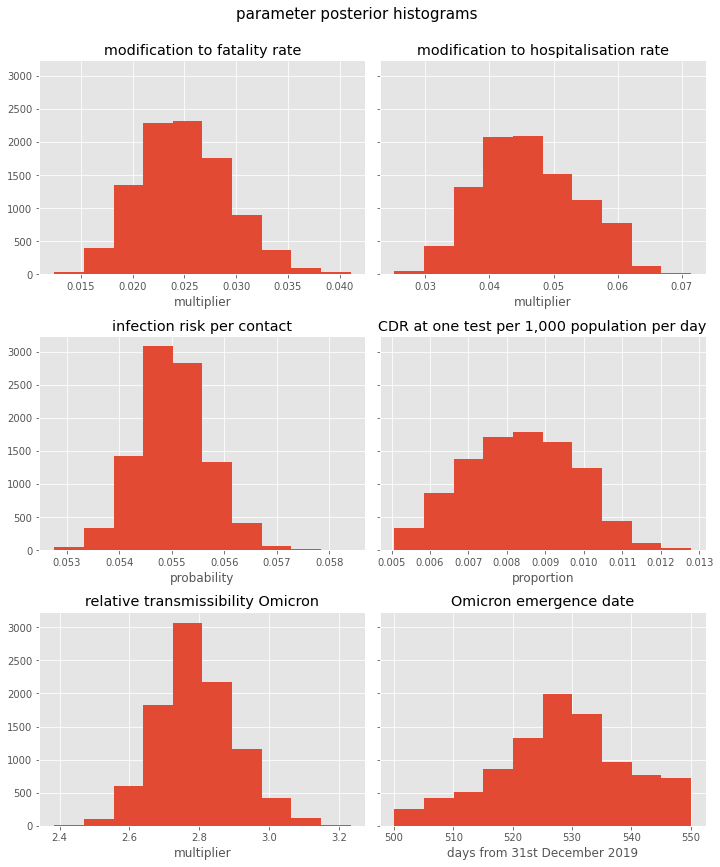

In [12]:
plt.style.use("ggplot")

param_lookup = {
    "contact_rate": "infection risk per contact",
    "testing_to_detection.assumed_cdr_parameter": "CDR at one test per 1,000 population per day",
    "voc_emergence.omicron.new_voc_seed.start_time": "Omicron emergence date",
    "voc_emergence.omicron.contact_rate_multiplier": "relative transmissibility Omicron",
    "age_stratification.cfr.multiplier": "modification to fatality rate",
    "age_stratification.prop_hospital.multiplier": "modification to hospitalisation rate",
}

unit_lookup = {
    "contact_rate": "probability",
    "testing_to_detection.assumed_cdr_parameter": "proportion",
    "voc_emergence.omicron.new_voc_seed.start_time": "days from 31st December 2019",
    "voc_emergence.omicron.contact_rate_multiplier": "multiplier",
    "age_stratification.cfr.multiplier": "multiplier",
    "age_stratification.prop_hospital.multiplier": "multiplier",
}

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey="all")
for i_ax, axis in enumerate(axes.reshape(-1)):
    param = mcmc_params.columns[i_ax]
    axis.hist(mcmc_params[param])
    axis.set_title(param_lookup[param])
    axis.set_xlabel(unit_lookup[param])
fig.suptitle("parameter posterior histograms", fontsize=15, y=1)
fig.tight_layout()

## Available model outputs are:

In [7]:
[col for col in full_run.columns if "X" not in col]

['chain',
 'run',
 'scenario',
 'times',
 'ever_infected',
 'ever_detected_incidence',
 'notifications',
 'infection_deaths',
 'icu_admissions',
 'icu_occupancy',
 'hospital_admissions',
 'hospital_occupancy',
 'incidence',
 'cdr',
 'total_population',
 'prop_ever_infected']

### Get all targets, including those not used in calibration, to use as a validation

In [8]:
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
model, country, run, commit = run_id.split("/")
project_file_path = os.path.join(project_root, "autumn", "projects", model, country, country, "timeseries.json")
all_targets = load_timeseries(project_file_path)
for target in all_targets:
    all_targets[target].index = ref_times_to_dti(REF_DATE, all_targets[target].index)

c:\tools\anaconda3\envs\autumn\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

c:\tools\anaconda3\envs\autumn\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

c:\tools\anaconda3\envs\autumn\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

c:\tools\anaconda3\envs\autumn\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use a

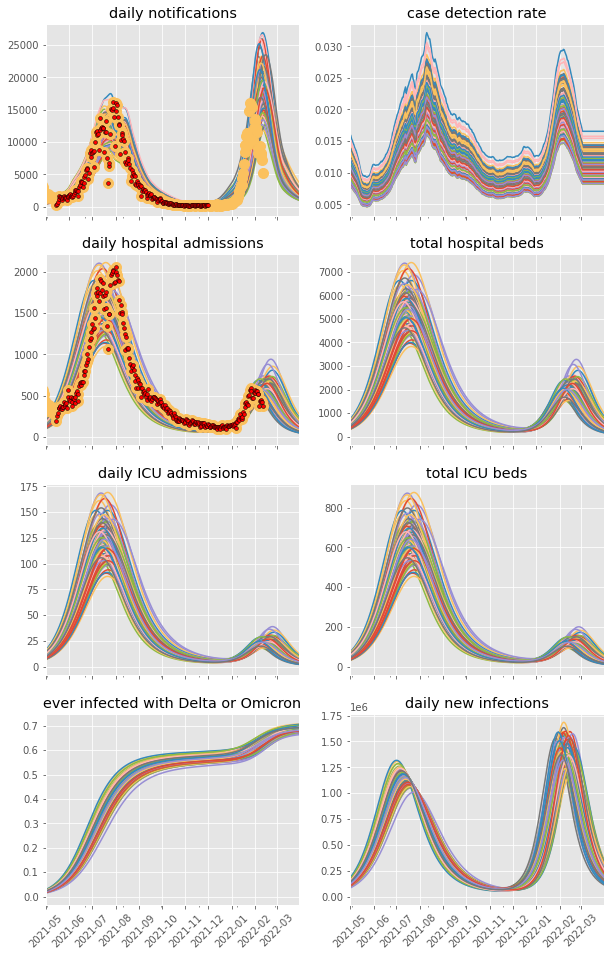

In [28]:
title_lookup = {
    "notifications": "daily notifications",
    "infection_deaths": "COVID-19-specific deaths",
    "hospital_admissions": "new daily hospital admissions",
    "icu_admissions": "new daily admissions to ICU",
    "proportion_seropositive": "proportion recovered from COVID-19",
    "incidence": "daily new infections",
    "prop_incidence_strain_delta": "proportion of cases due to Delta",
    "hospital_admissions": "daily hospital admissions",
    "hospital_occupancy": "total hospital beds",
    "icu_admissions": "daily ICU admissions",
    "icu_occupancy": "total ICU beds",
    "prop_ever_infected": "ever infected with Delta or Omicron",
    "cdr": "case detection rate",
}

fig, axes = plt.subplots(4, 2, figsize=(10, 18), sharex="all")
plot_left_date = datetime.date(2021, 5, 1)
plot_right_date = datetime.date(2022, 3, 31)
outputs = (
    "notifications", 
    "cdr",
    "hospital_admissions",
    "hospital_occupancy",
    "icu_admissions", 
    "icu_occupancy",
    "prop_ever_infected",
    "incidence",
)
for i_ax, axis in enumerate(axes.reshape(-1)):
    output = outputs[i_ax]
    scenario_chain = (full_run["scenario"] == 0) & (full_run["chain"] == 0)
    for i_run in full_run[scenario_chain]["run"].unique():
        selection = full_run[(full_run["run"] == i_run) & scenario_chain]
        axis.plot(ref_times_to_dti(REF_DATE, selection["times"]), selection[output])
    if output in all_targets and len(all_targets[output]) > 0:
        all_targets[output].plot.line(ax=axis, linewidth=0., markersize=10., marker="o")
#         axis.scatter(all_targets[output].index, all_targets[output], color="k", s=5, alpha=0.5, zorder=10)
    if output in targets:
        axis.scatter(targets.index, targets[output], facecolors="r", edgecolors="k", s=15, zorder=10)
    axis.tick_params(axis="x", labelrotation=45)
    axis.set_title(title_lookup[output])
    axis.set_xlim(left=plot_left_date, right=plot_right_date)

In [10]:
def plot_outputs(outputs, left_date, right_date):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex="all")
    colour = (0.2, 0.2, 0.8)
    for i_ax, axis in enumerate(axes.reshape(-1)):
        output = outputs[i_ax]
        results_df = results[(output, 0)]
        indices = results_df.index
        axis.fill_between(indices, results_df[0.025], results_df[0.975], color=colour, alpha=0.5)
        axis.fill_between(indices, results_df[0.25], results_df[0.75], color=colour, alpha=0.7)
        axis.plot(indices, results_df[0.500], color="b")
        if output in targets:
            axis.scatter(targets.index, targets[output], color="k", alpha=0.5, s=10)
        axis.tick_params(axis="x", labelrotation=45)
        axis.set_xlim(left=left_date, right=right_date)
        axis.set_title(title_lookup[output])
    fig.tight_layout()

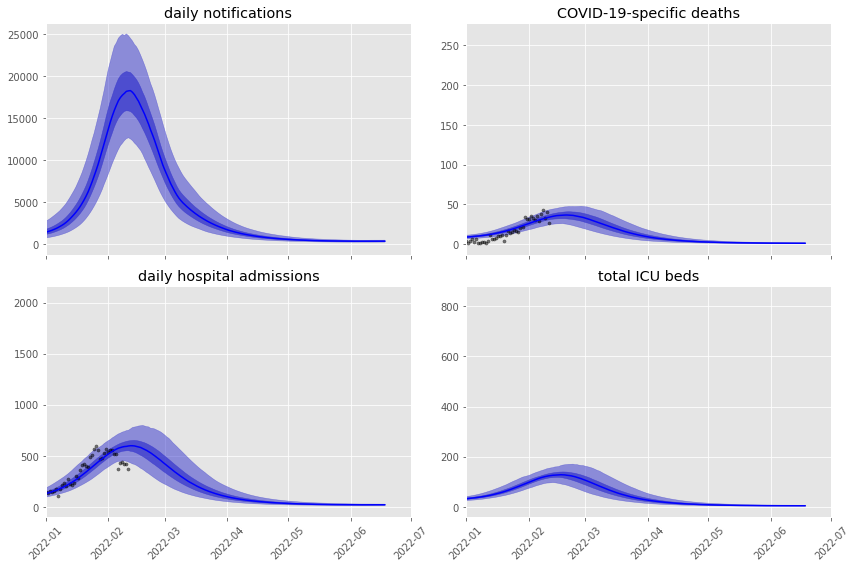

In [11]:
left_date = datetime.date(2022, 1, 1)
right_date = datetime.date(2022, 7, 1)
outputs_to_plot = (
    "notifications", 
    "infection_deaths",
    "hospital_admissions",
    "icu_occupancy",
)
plot_outputs(outputs_to_plot, left_date, right_date)